In [4]:
!pip install nltk

In [5]:
import numpy as np
import pickle  # for saving model
import os
import pandas as pd
import re



import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.special import digamma, softmax
from scipy.special import gammaln
import random


import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("magdawjcicka/amazon-reviews-2018-electronics")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-reviews-2018-electronics


In [7]:
df = pd.read_csv(os.path.join(path, 'electronics_small.csv'))

# Check the first few rows
print(df.head())

   overall  vote  verified  reviewTime  \
0        5    67      True  1999-09-18   
1        3     5      True  2013-10-23   
2        5     4      True  2008-09-02   
3        5    13      True  2000-09-04   
4        3     8      True  2000-02-04   

                                          reviewText  \
0  This is the best novel I have read in 2 or 3 y...   
1  Pages and pages of introspection, in the style...   
2  This is the kind of novel to read when you hav...   
3  What gorgeous language! What an incredible wri...   
4  I was taken in by reviews that compared this b...   

                                             summary  
0                                     A star is born  
1                    A stream of consciousness novel  
2  I'm a huge fan of the author and this one did ...  
3          The most beautiful book I have ever read!  
4                        A dissenting view--In part.  


Unique star ratings and counts:
overall
5    1909431
4     520339
3     228272
1     205790
2     136168
Name: count, dtype: int64


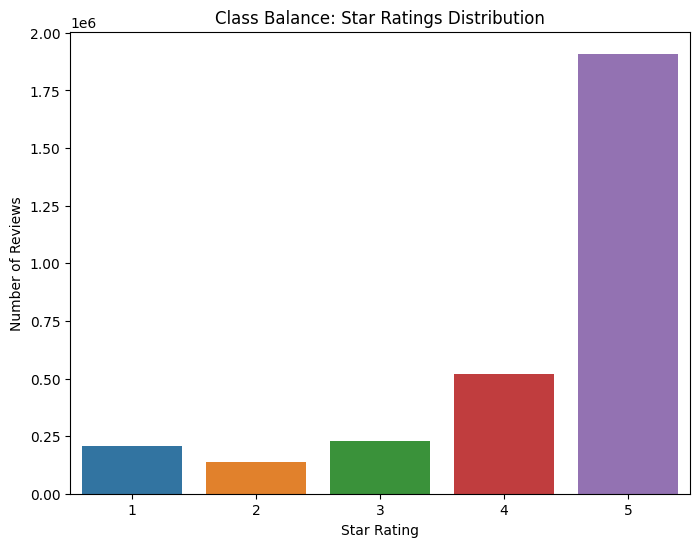


Class Percentage Distribution:
overall
5    63.647700
4    17.344633
3     7.609067
1     6.859667
2     4.538933
Name: proportion, dtype: float64


In [8]:
# Check label distribution
print("Unique star ratings and counts:")
print(df['overall'].value_counts())

# Visualize class balance
plt.figure(figsize=(8,6))
sns.countplot(x='overall', data=df, order=sorted(df['overall'].unique()))
plt.title("Class Balance: Star Ratings Distribution")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

# Show % distribution
class_counts = df['overall'].value_counts(normalize=True) * 100
print("\nClass Percentage Distribution:")
print(class_counts)

**Merging the summary and the review text**

In [12]:
# Merge reviewText and summary into full_text
df['reviewText'] = df['reviewText'].fillna('').astype(str)
df['summary'] = df['summary'].fillna('').astype(str)

df['full_text'] = df['reviewText'] + ' ' + df['summary']


# Check sample
print(df['full_text'].head())

0    This is the best novel I have read in 2 or 3 y...
1    Pages and pages of introspection, in the style...
2    This is the kind of novel to read when you hav...
3    What gorgeous language! What an incredible wri...
4    I was taken in by reviews that compared this b...
Name: full_text, dtype: object


# **Cleaning up the data**


1.   Making text lowercase
2.   Removing unwanted characters
3.   splitting by white space
4.   removing stop words



In [13]:
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
#print(stops)

if "the" in stops: #sanity checkkkkk - for me  X/
  print(True)

True


In [15]:
stop_words = stops

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)


In [16]:
# Apply text cleaning
df['cleaned_text'] = df['full_text'].apply(clean_text)

# Preview a few cleaned rows
print(df[['full_text', 'cleaned_text']].head())


                                           full_text  \
0  This is the best novel I have read in 2 or 3 y...   
1  Pages and pages of introspection, in the style...   
2  This is the kind of novel to read when you hav...   
3  What gorgeous language! What an incredible wri...   
4  I was taken in by reviews that compared this b...   

                                        cleaned_text  
0  best novel read years everything fiction beaut...  
1  pages pages introspection style writers like h...  
2  kind novel read time lose book days possibly w...  
3  gorgeous language incredible writer last life ...  
4  taken reviews compared book leopard promised b...  


In [17]:
# Vectorization (already done earlier)
vectorizer = CountVectorizer(max_features=3000)
X_bow = vectorizer.fit_transform(df['cleaned_text'])
print("Shape of sparse document-term matrix:", X_bow.shape)

# Extract labels
y = df['overall'].astype(int).values  # convert to integer labels

# Remove empty documents
nonempty_mask = (X_bow.sum(axis=1) > 0).A1  # flatten sparse sum
X_bow = X_bow[nonempty_mask]
y = y[nonempty_mask]
print("After removing empty docs:", X_bow.shape)

# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bow, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # this preserves class balance across splits!
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Shape of sparse document-term matrix: (3000000, 3000)
After removing empty docs: (2967811, 3000)
Train shape: (2374248, 3000)
Test shape: (593563, 3000)


**Building the Model**

# Implementation for SLDA

In [18]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SupervisedLDA_PyTorch:
    def __init__(self, n_topics, vocab_size, alpha=0.1, beta_prior=0.01, sigma2=1.0, tau0=1.0, kappa=0.9):
        self.n_topics = n_topics
        self.vocab_size = vocab_size
        self.alpha = torch.full((n_topics,), alpha, device=device)
        self.beta_prior = beta_prior
        self.sigma2 = sigma2
        self.tau0 = tau0
        self.kappa = kappa
        self.update_count = 0
        self.is_fitted = False
        self._initialize_parameters()

    def _initialize_parameters(self):
        self.beta = torch.distributions.Dirichlet(torch.full((self.vocab_size,), self.beta_prior)).sample((self.n_topics,)).to(device)
        self.eta = torch.randn(self.n_topics, device=device) * 0.1

    def _variational_inference(self, docs, responses, max_iter=50, tol=1e-6):
      batch_size = docs.shape[0]
      word_sums = torch.sum(docs, dim=1, keepdim=True)  # shape: (batch_size, 1)
      word_sums = torch.clamp(word_sums, min=1e-8)

      # Initialize gamma and phi
      gamma = self.alpha.unsqueeze(0).repeat(batch_size, 1) + word_sums / self.n_topics
      phi = torch.full((batch_size, self.vocab_size, self.n_topics), 1.0 / self.n_topics, device=device)

      log_beta = torch.log(self.beta + 1e-12)

      for it in range(max_iter):
          gamma_old = gamma.clone()

          # Compute digamma terms once
          # Compute digamma terms once
          digamma_gamma = torch.digamma(gamma)  # shape: (batch_size, n_topics)
          digamma_sum_gamma = torch.digamma(torch.sum(gamma, dim=1, keepdim=True))  # shape: (batch_size, 1)

          # Compute theta means
          theta_mean = gamma / torch.sum(gamma, dim=1, keepdim=True)

          # Compute supervision term
          residual = (responses - torch.sum(self.eta * theta_mean, dim=1)).unsqueeze(1)
          supervision = (self.eta / self.sigma2).unsqueeze(0) * residual / word_sums  # shape: (batch_size, n_topics)

          # Vectorized log_phi
          log_phi = digamma_gamma.unsqueeze(1).expand(-1, self.vocab_size, -1) - digamma_sum_gamma.unsqueeze(1)
          log_phi += log_beta.T.unsqueeze(0)
          log_phi += supervision.unsqueeze(1)


          # Softmax over topics (axis=2)
          phi = F.softmax(log_phi, dim=2)

          # Update gamma
          phi_weighted = phi * docs.unsqueeze(2)  # shape: (batch_size, vocab_size, n_topics)
          gamma = self.alpha + torch.sum(phi_weighted, dim=1)

          # Check convergence
          if torch.mean(torch.abs(gamma - gamma_old)) < tol:
              break

      return gamma, phi


    def _compute_sufficient_statistics(self, docs, phi, responses, gamma):
        # beta_ss shape should be (n_topics, vocab_size)
        beta_ss = torch.einsum('bvn,bv->nv', phi, docs) # Corrected einsum
        theta = gamma / torch.sum(gamma, dim=1, keepdim=True)
        theta_theta = torch.einsum('bi,bj->bij', theta, theta).sum(dim=0)
        theta_y = torch.einsum('bi,b->i', theta, responses)
        return beta_ss, theta_theta, theta_y

    def _update_global_parameters(self, beta_ss, theta_theta, theta_y, batch_size, total_docs):
        rho_t = torch.tensor((self.tau0 + self.update_count) ** (-self.kappa), device=device)
        self.update_count += 1
        scale = total_docs / batch_size

        beta_ss *= scale
        beta_prior_tensor = torch.full_like(self.beta, self.beta_prior)

        self.beta = (1 - rho_t) * self.beta + rho_t * (beta_ss + beta_prior_tensor)
        self.beta /= torch.sum(self.beta, dim=1, keepdim=True)

        theta_theta *= scale
        theta_y *= scale

        # Add small ridge penalty to ensure numerical stability
        reg_strength = 1e-3  # (this value can be tuned)

        reg = torch.eye(self.n_topics, device=device) * reg_strength

        # Use least-squares solver instead of solve() to avoid singular matrix errors
        eta_new = torch.linalg.lstsq(theta_theta + reg, theta_y.unsqueeze(1)).solution.squeeze()

        # Exponential moving average update
        self.eta = (1 - rho_t) * self.eta + rho_t * eta_new




    def fit(self, X, y, n_epochs=10, batch_size=1024):
        #X = torch.tensor(X, dtype=torch.float32, device=device)
        #y = torch.tensor(y, dtype=torch.float32, device=device)
        X = torch.tensor(X, dtype=torch.float32, device="cpu")
        y = torch.tensor(y, dtype=torch.float32, device="cpu")

        n_docs = X.shape[0]

        for epoch in range(n_epochs):
            indices = torch.randperm(n_docs, device=device)
            for batch_start in range(0, n_docs, batch_size):
                batch_end = min(batch_start + batch_size, n_docs)
                batch_indices = indices[batch_start:batch_end]
                #docs = X[batch_indices]
                #responses = y[batch_indices]
                batch_indices = torch.tensor(batch_indices, device="cpu")
                docs = X[batch_indices].to(device)
                responses = y[batch_indices].to(device)


                gamma, phi = self._variational_inference(docs, responses)
                beta_ss, theta_theta, theta_y = self._compute_sufficient_statistics(docs, phi, responses, gamma)
                self._update_global_parameters(beta_ss, theta_theta, theta_y, len(batch_indices), n_docs)
            print(f"Epoch {epoch+1}/{n_epochs} completed.")

        self.is_fitted = True

    def predict(self, X, batch_size=1024):
        if not self.is_fitted:
            raise ValueError("Model must be fitted first.")
        X = torch.tensor(X, dtype=torch.float32, device=device)
        n_docs = X.shape[0]
        preds = []
        for batch_start in range(0, n_docs, batch_size):
            batch_end = min(batch_start + batch_size, n_docs)
            docs = X[batch_start:batch_end]
            responses_dummy = torch.zeros(docs.shape[0], device=device)
            gamma, _ = self._variational_inference(docs, responses_dummy)
            theta = gamma / torch.sum(gamma, dim=1, keepdim=True)
            pred = torch.sum(self.eta.unsqueeze(0) * theta, dim=1)
            preds.extend(pred.cpu().numpy())
        return np.array(preds)

    def save_model(self, filepath):
        model_dict = {
            'n_topics': self.n_topics,
            'vocab_size': self.vocab_size,
            'alpha': self.alpha.cpu().numpy(),
            'beta_prior': self.beta_prior,
            'sigma2': self.sigma2,
            'tau0': self.tau0,
            'kappa': self.kappa,
            'update_count': self.update_count,
            'beta': self.beta.cpu().numpy(),
            'eta': self.eta.cpu().numpy(),
            'is_fitted': self.is_fitted
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_dict, f)

    def load_model(self, filepath):
        with open(filepath, 'rb') as f:
            model_dict = pickle.load(f)
        self.n_topics = model_dict['n_topics']
        self.vocab_size = model_dict['vocab_size']
        self.alpha = torch.tensor(model_dict['alpha'], device=device)
        self.beta_prior = model_dict['beta_prior']
        self.sigma2 = model_dict['sigma2']
        self.tau0 = model_dict['tau0']
        self.kappa = model_dict['kappa']
        self.update_count = model_dict['update_count']
        self.beta = torch.tensor(model_dict['beta'], device=device)
        self.eta = torch.tensor(model_dict['eta'], device=device)
        self.is_fitted = model_dict['is_fitted']

In [19]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (2374248, 3000)
Test shape: (593563, 3000)


# Finding the optimal value for topics k

Using device: cuda

Training with 5 topics...
Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.
RMSE for 5 topics: 1.2031
✅ New best model saved for 5 topics

Training with 8 topics...
Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.
RMSE for 8 topics: 1.4173

Training with 10 topics...
Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.
RMSE for 10 topics: 1.7992

Training with 12 topics...
Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch

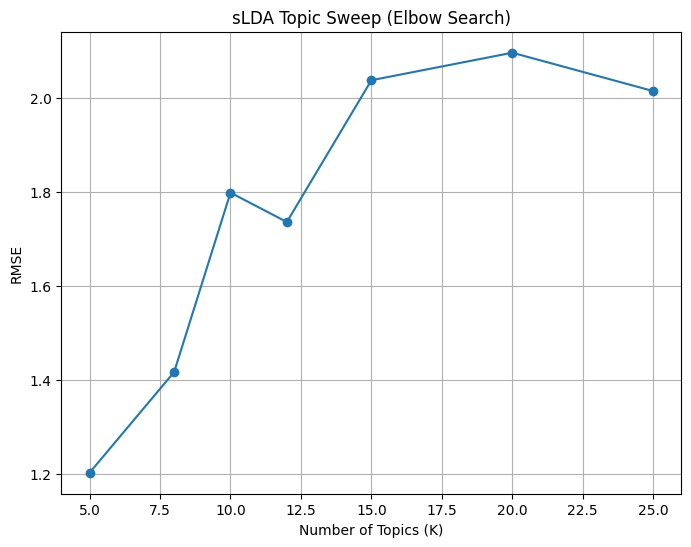

In [35]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Subsample safely for sweep 
subsample_size = 100_000  
indices = np.random.choice(X_train.shape[0], size=subsample_size, replace=False)
X_sub_sparse = X_train[indices]
y_sub = y_train[indices]

#  Convert subsample to dense for PyTorch model
X_sub_dense = X_sub_sparse.toarray().astype(np.float32)

#  Define the topic sweep values to test
topic_grid = [5, 8, 10, 12, 15, 20, 25] 

# Initialize trackers
results = []
best_model = None
best_rmse = np.inf
best_n_topics = None

# Loop over candidate topic numbers
for n_topics in topic_grid:
    print(f"\nTraining with {n_topics} topics...")

    # Instantiate model
    model = SupervisedLDA_PyTorch(
        n_topics=n_topics,
        vocab_size=3000,  # <-- match your CountVectorizer max_features
        alpha=0.1,
        beta_prior=0.01,
        sigma2=1.0,
        tau0=1024,
        kappa=0.7
    )

    # Train on subsample
    model.fit(X_sub_dense, y_sub, n_epochs=10, batch_size=512)

    # Evaluate on subsample 
    preds = model.predict(X_sub_dense)
    rmse = np.sqrt(mean_squared_error(y_sub, preds))
    print(f"RMSE for {n_topics} topics: {rmse:.4f}")

    # Store result
    results.append((n_topics, rmse))

    # Check if this is best so far
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_n_topics = n_topics
        model.save_model(f"best_slda_topics_{n_topics}.pkl")
        print(f"✅ New best model saved for {n_topics} topics")

# Sort and print results
results.sort(key=lambda x: x[0])
print("\nTopic sweep complete:")
for n_topics, rmse in results:
    print(f"{n_topics} topics: RMSE = {rmse:.4f}")

print(f"\n✅ Best number of topics: {best_n_topics} with RMSE = {best_rmse:.4f}")

# Plot elbow curve
topics = [r[0] for r in results]
rmses = [r[1] for r in results]

plt.figure(figsize=(8,6))
plt.plot(topics, rmses, marker='o')
plt.xlabel("Number of Topics (K)")
plt.ylabel("RMSE")
plt.title("sLDA Topic Sweep (Elbow Search)")
plt.grid()
plt.show()


**Full training on model**

In [41]:
print(best_n_topics)

5


In [42]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate model with your final K = best model n topics 
model = SupervisedLDA_PyTorch(
    n_topics=best_n_topics,
    vocab_size=3000,
    alpha=0.1,
    beta_prior=0.01,
    sigma2=1.0,
    tau0=1024,
    kappa=0.7
)

# Updated full training parameters
n_epochs = 60  # <-- increased from 30 to 60 to fix undertraining
outer_batch_size = 100_000  
model_batch_size = 16_384  
best_rmse = np.inf

# Full training loop with monitoring
#using emojist because I cannot read anymore plain text -- ew
for epoch in range(n_epochs):
    print(f"\n🔄 Starting epoch {epoch+1}/{n_epochs}")

    # Randomly sample a new sparse batch from full train data
    indices = np.random.choice(X_train.shape[0], size=outer_batch_size, replace=False)
    X_batch_sparse = X_train[indices]
    y_batch = y_train[indices]

    # Convert batch to dense
    X_batch_dense = X_batch_sparse.toarray().astype(np.float32)

    # Train on dense batch for 1 epoch
    model.fit(X_batch_dense, y_batch, n_epochs=1, batch_size=model_batch_size)

    # RMSE monitoring on batch
    preds = model.predict(X_batch_dense)
    rmse = np.sqrt(mean_squared_error(y_batch, preds))
    print(f"Epoch {epoch+1}: Batch RMSE = {rmse:.4f}")

    # Save best checkpoint
    if rmse < best_rmse:
        best_rmse = rmse
        model.save_model("best_full_slda_model.pkl")
        print(f"✅ New best model saved at epoch {epoch+1}")

print("\n✅ Full training complete!")


Using device: cuda

🔄 Starting epoch 1/60
Epoch 1/1 completed.
Epoch 1: Batch RMSE = 4.1666
✅ New best model saved at epoch 1

🔄 Starting epoch 2/60
Epoch 1/1 completed.
Epoch 2: Batch RMSE = 3.9712
✅ New best model saved at epoch 2

🔄 Starting epoch 3/60
Epoch 1/1 completed.
Epoch 3: Batch RMSE = 3.7796
✅ New best model saved at epoch 3

🔄 Starting epoch 4/60
Epoch 1/1 completed.
Epoch 4: Batch RMSE = 3.5968
✅ New best model saved at epoch 4

🔄 Starting epoch 5/60
Epoch 1/1 completed.
Epoch 5: Batch RMSE = 3.4286
✅ New best model saved at epoch 5

🔄 Starting epoch 6/60
Epoch 1/1 completed.
Epoch 6: Batch RMSE = 3.2729
✅ New best model saved at epoch 6

🔄 Starting epoch 7/60
Epoch 1/1 completed.
Epoch 7: Batch RMSE = 3.1298
✅ New best model saved at epoch 7

🔄 Starting epoch 8/60
Epoch 1/1 completed.
Epoch 8: Batch RMSE = 2.9883
✅ New best model saved at epoch 8

🔄 Starting epoch 9/60
Epoch 1/1 completed.
Epoch 9: Batch RMSE = 2.8521
✅ New best model saved at epoch 9

🔄 Starting epoch 

In [44]:
# Move saved model into Kaggle output directory (for easy download)
import shutil

shutil.move("best_full_slda_model.pkl", "/kaggle/working/best_full_slda_model.pkl")
print("✅ Model file saved for download.")


✅ Model file saved for download.


**Visualizations**

In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-instantiate model object 
model = SupervisedLDA_PyTorch(
    n_topics=8,         
    vocab_size=3000,   
    alpha=0.1,
    beta_prior=0.01,
    sigma2=1.0,
    tau0=1024,
    kappa=0.7
)

# load weights
model.load_model("/kaggle/input/model5/best_full_slda_model (1).pkl")
#model.load_model("best_full_slda_model.pkl")

print("✅ Model loaded successfully")


✅ Model loaded successfully


In [22]:
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to extract theta in batches
def extract_theta(model, X_sparse, y_array, outer_batch_size=100000, inner_batch_size=4096):
    theta_list = []

    for i in range(0, X_sparse.shape[0], outer_batch_size):
        X_batch_sparse = X_sparse[i:i+outer_batch_size]
        y_batch = y_array[i:i+outer_batch_size]
        X_batch_dense = X_batch_sparse.toarray().astype(np.float32)

        batch_gamma_list = []
        for j in range(0, X_batch_dense.shape[0], inner_batch_size):
            X_inner = X_batch_dense[j:j+inner_batch_size]
            y_inner = y_batch[j:j+inner_batch_size]

            gamma, phi = model._variational_inference(
                torch.tensor(X_inner).to(device),
                torch.tensor(y_inner).to(device)
            )
            gamma_np = gamma.cpu().detach().numpy()
            batch_gamma_list.append(gamma_np)

        gamma_full_batch = np.vstack(batch_gamma_list)
        theta = gamma_full_batch / gamma_full_batch.sum(axis=1, keepdims=True)
        theta_list.append(theta)

    theta_full = np.vstack(theta_list)
    return theta_full


✅ Linear Regression RMSE: 0.9391
✅ Linear Regression Accuracy (rounded): 0.5372

Classification Report (rounded):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     40467
           2       0.19      0.22      0.20     26711
           3       0.15      0.24      0.19     44612
           4       0.21      0.31      0.25    103149
           5       0.78      0.72      0.75    378624

    accuracy                           0.54    593563
   macro avg       0.27      0.29      0.28    593563
weighted avg       0.55      0.54      0.54    593563



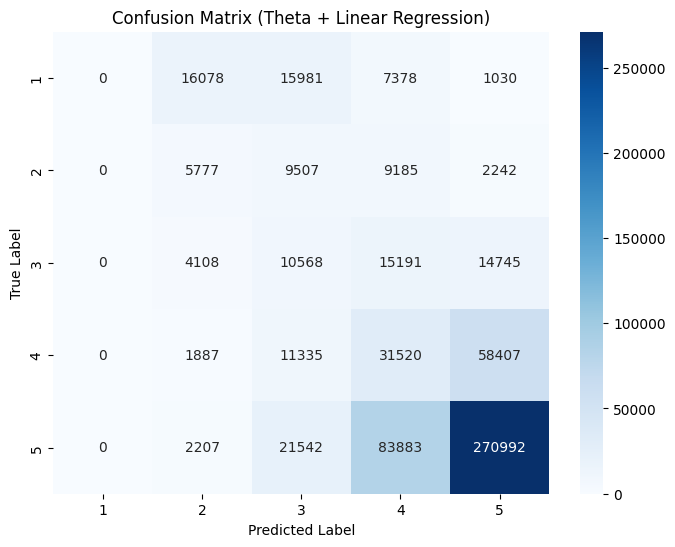

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight


#  Extract theta for train
train_theta = extract_theta(model, X_train, y_train)

#  Extract theta for test
test_theta = extract_theta(model, X_test, y_test)


#  Train linear regression on theta features
reg = LinearRegression()
reg.fit(train_theta, y_train)

#  Predict on test set
y_pred_continuous = reg.predict(test_theta)

#  Evaluate true RMSE (regression error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_continuous))
print(f"✅ Linear Regression RMSE: {rmse:.4f}")

#  Convert predictions to discrete classes for classification evaluation
y_pred_discrete = np.clip(np.round(y_pred_continuous), 1, 5).astype(int)

#  Evaluate classification accuracy
accuracy = accuracy_score(y_test, y_pred_discrete)
print(f"✅ Linear Regression Accuracy (rounded): {accuracy:.4f}")

#  Classification report
print("\nClassification Report (rounded):")
print(classification_report(y_test, y_pred_discrete))

#  Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_discrete)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Theta + Linear Regression)")
plt.show()


**#Trying ordinal regression**

In [26]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=b04cdc60cba4a9fe994c7cef5518ee95944a6342c462c4c9f61f88fe8dc27044
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


✅ Ordinal Regression RMSE: 1.0100
✅ Ordinal Regression Accuracy: 0.6131

Classification Report (Ordinal):
              precision    recall  f1-score   support

           1       0.55      0.14      0.22     40467
           2       0.18      0.18      0.18     26711
           3       0.15      0.13      0.14     44612
           4       0.20      0.14      0.17    103149
           5       0.75      0.88      0.81    378624

    accuracy                           0.61    593563
   macro avg       0.37      0.29      0.30    593563
weighted avg       0.57      0.61      0.58    593563



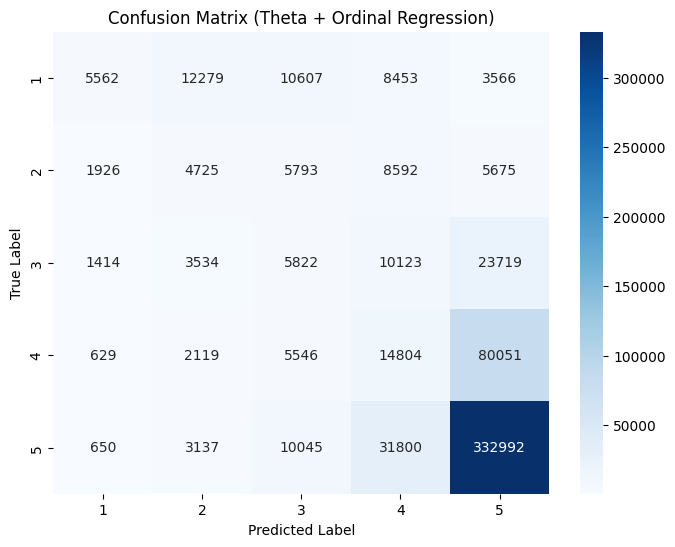

In [29]:
import mord
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

#  Train ordinal regression on theta features
ordinal_model = mord.LogisticAT(alpha=1.0)  # "All Thresholds" ordinal regression
ordinal_model.fit(train_theta, y_train)

#  Predict on test set
y_pred_ordinal = ordinal_model.predict(test_theta)

#  Evaluate RMSE (since output is discrete, we still compute RMSE over integers)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ordinal))
print(f"✅ Ordinal Regression RMSE: {rmse:.4f}")

#  Evaluate classification accuracy
accuracy = accuracy_score(y_test, y_pred_ordinal)
print(f"✅ Ordinal Regression Accuracy: {accuracy:.4f}")

#  Classification report
print("\nClassification Report (Ordinal):")
print(classification_report(y_test, y_pred_ordinal))

#  Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_ordinal)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Theta + Ordinal Regression)")
plt.show()

# Baseline Model Estimation

In [33]:
# Vectorization (already done earlier)
vectorizer = CountVectorizer(max_features=3000)
X_bow = vectorizer.fit_transform(df['cleaned_text'])
print("Shape of sparse document-term matrix:", X_bow.shape)

# Extract labels
y = df['overall'].astype(int).values  # convert to integer labels

# Remove empty documents
nonempty_mask = (X_bow.sum(axis=1) > 0).A1  # flatten sparse sum
X_bow = X_bow[nonempty_mask]
y = y[nonempty_mask]
print("After removing empty docs:", X_bow.shape)

# Stratified Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bow, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # this preserves class balance across splits!
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Shape of sparse document-term matrix: (3000000, 3000)
After removing empty docs: (2967811, 3000)
Train shape: (2374248, 3000)
Test shape: (593563, 3000)


✅ BoW Linear Regression RMSE: 0.9530
✅ BoW Linear Regression Accuracy (rounded): 0.4691

Classification Report (BoW Linear):
              precision    recall  f1-score   support

           1       0.60      0.07      0.13     40467
           2       0.19      0.07      0.10     26711
           3       0.27      0.26      0.27     44612
           4       0.24      0.80      0.37    103149
           5       0.91      0.47      0.62    378624

    accuracy                           0.47    593563
   macro avg       0.44      0.34      0.30    593563
weighted avg       0.70      0.47      0.50    593563



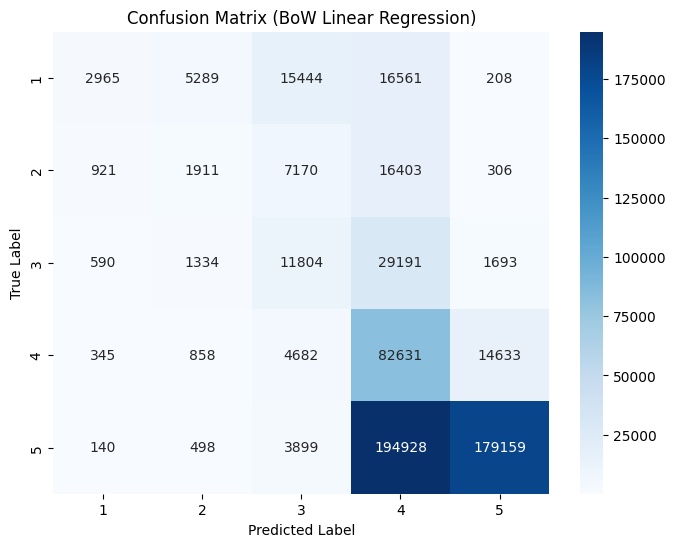

In [35]:
from sklearn.linear_model import LinearRegression

#  Train linear regression on BoW features
reg_bow = LinearRegression()
reg_bow.fit(X_train, y_train)

#  Predict on test set
y_pred_bow_cont = reg_bow.predict(X_test)

#  Evaluate true RMSE (regression error)
rmse_bow = np.sqrt(mean_squared_error(y_test, y_pred_bow_cont))
print(f"✅ BoW Linear Regression RMSE: {rmse_bow:.4f}")

#  Convert predictions to discrete classes for classification evaluation
y_pred_bow_discrete = np.clip(np.round(y_pred_bow_cont), 1, 5).astype(int)

#  Evaluate classification accuracy
accuracy_bow = accuracy_score(y_test, y_pred_bow_discrete)
print(f"✅ BoW Linear Regression Accuracy (rounded): {accuracy_bow:.4f}")

#  Classification report
print("\nClassification Report (BoW Linear):")
print(classification_report(y_test, y_pred_bow_discrete))

#  Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_bow_discrete)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (BoW Linear Regression)")
plt.show()
